In [13]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import quandl
import scipy
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

sns.set_style('whitegrid')

In [14]:
#load datasets
quandl.ApiConfig.api_key = '1x62xPokqcRhHMTZH3ok'
data = quandl.get_table('WIKI/PRICES', ticker = ['AAPL','AMZN', 'FB' , 'CAT', 'CCL', 'KO', 'XOM', 'ABT', 'MMM', 'JNJ', 'NFLX', 'GOOGL', 'TSLA', 'BABA', 'NVDA', 'AXP', 'BBY', 'CMCSA', 'EA', 'INTC', 'JNPR', 'LLL'], 
                        qopts = { 'columns': ['ticker', 'date', 'high', 'low','open', 'close', 'volume'] }, 
                        date = { 'gte': '2012-05-01', 'lte': '2018-05-01' },
                        paginate = True)

data.columns = ['symbol', 'date', 'high', 'low','open', 'close', 'volume']

#save to csv
data.to_csv("./file2.csv", sep=',',index=False)

#start_sp = datetime.datetime(2012, 5, 1)
#end_sp = datetime.datetime(2018, 5, 1)

#yf.pdr_override() # <== that's all it takes :-)
#sp500 = pdr.get_data_yahoo('^GSPC', 
#                           start_sp,
#                             end_sp)

#sp500.head()

data.head()

,symbol,date,high,low,open,close,volume
None,,,,,,,
0,AAPL,2012-05-01,596.7600,581.23,584.90,582.13,21821400.0
1,AAPL,2012-05-02,587.3999,578.86,580.24,585.98,15263900.0
2,AAPL,2012-05-03,591.4000,580.30,590.50,581.82,13948200.0
3,AAPL,2012-05-04,578.3600,565.17,577.08,565.25,18928300.0
4,AAPL,2012-05-07,572.7700,561.23,561.50,569.48,16432800.0


In [16]:
data["change"] = data["close"] - data["open"]
df_interest = data[["symbol", "date", "open", "close", "change", "volume"]]
df_interest["date"] = pd.to_datetime(data["date"])
df_interest.head()

/home/bda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,symbol,date,open,close,change,volume
None,,,,,,
0,AAPL,2012-05-01,584.90,582.13,-2.77,21821400.0
1,AAPL,2012-05-02,580.24,585.98,5.74,15263900.0
2,AAPL,2012-05-03,590.50,581.82,-8.68,13948200.0
3,AAPL,2012-05-04,577.08,565.25,-11.83,18928300.0
4,AAPL,2012-05-07,561.50,569.48,7.98,16432800.0


In [17]:
from __future__ import division

# Get each symbols standard deviation in time
ss = df_interest.groupby(by=["symbol"])["change"].std()

# Count each symbol groups positive day change in time
## NOTE: it is a proportion to account for some days not appearing for some symbols in time
pcs = df_interest.groupby(by='symbol').apply(lambda grp: grp[grp['change'] > 0]['change'].count() / grp['change'].size)

avgv = df_interest.groupby(by=['symbol'])['volume'].mean()/10000000

newdf = pd.concat([ss, pcs, avgv], axis=1).reset_index()
newdf.columns = ['symbol', 'std', 'prop_pos_day_change', "avg_volume"]
newdf.head()

,symbol,std,prop_pos_day_change,avg_volume
0,AAPL,4.362328,0.506065,3.159037
1,ABT,0.470225,0.526280,0.789915
2,AMZN,8.837037,0.494609,0.372956
3,AXP,0.753469,0.520539,0.483329
4,BBY,0.661406,0.512458,0.611022


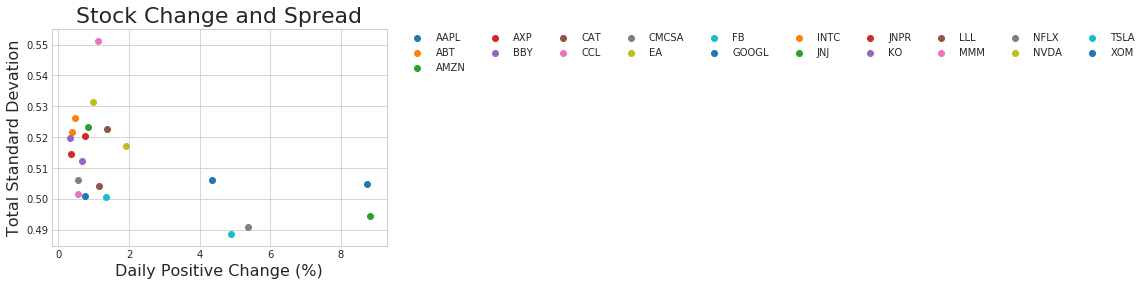

<Figure size 720x7200 with 0 Axes>

In [18]:
for i in newdf['symbol'].tolist():
    x = newdf[newdf['symbol'] == i]['std']
    y = newdf[newdf['symbol'] == i]['prop_pos_day_change']
    plt.scatter(x,y)
plt.legend(newdf['symbol'].tolist(),
           bbox_to_anchor=(1.05, 1),
           loc=2,
           borderaxespad=0.,
          ncol=10)


plt.title('Stock Change and Spread', fontsize=22)
plt.xlabel('Daily Positive Change (%)', fontsize=16)
plt.ylabel('Total Standard Devation', fontsize=16)
plt.figure(figsize=(10,100))
plt.show()

In [31]:
# Visualize K = {3..9}
kValues = [i for i in range(2,10)]
for k in kValues:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(newdf[['std','prop_pos_day_change']].as_matrix())
    newdf[str(k)] = kmeans.labels_
    print("Finished k=", k)

newdf = pd.melt(newdf, 
                id_vars=["symbol", 'std', 'prop_pos_day_change'],
                var_name="k", 
                value_name="values",
                value_vars=list(newdf.columns[-8:]))

newdf.head()

/home/bda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Finished k= 2
Finished k= 3
Finished k= 4
Finished k= 5
Finished k= 6
Finished k= 7
Finished k= 8
Finished k= 9


,symbol,std,prop_pos_day_change,k,values
0,AAPL,4.362328,0.506065,2,1
1,ABT,0.470225,0.526280,2,0
2,AMZN,8.837037,0.494609,2,1
3,AXP,0.753469,0.520539,2,0
4,BBY,0.661406,0.512458,2,0


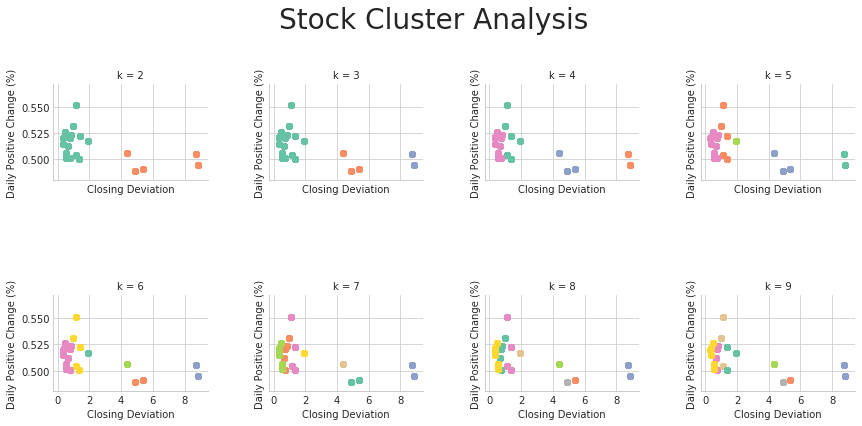

In [32]:
g = sns.FacetGrid(newdf, col="k", hue="values", col_wrap=4, palette='Set2')
g = g.map(plt.scatter, "std", "prop_pos_day_change")
g.set(xlabel="Closing Deviation")
g.set(ylabel="Daily Positive Change (%)")
g.fig.suptitle("Stock Cluster Analysis", size=28)
g.fig.subplots_adjust(top=.8)
plt.subplots_adjust(hspace=1.2, wspace=0.4)
#g.add_legend()
#g._legend.set_title("Cluster")
#handles = g._legend_data.values()
#labels = g._legend_data.keys()
#g.fig.legend(handles=handles, labels=labels, loc='lower right', ncol=3)